In [1]:
import pandas as pd

In [2]:
# Path to the CSV file
csvFile = 'data/open-meteo-43.69N7.19E17m.csv'

# Read the CSV file using pandas
data = pd.read_csv(csvFile)


In [3]:
data.dropna(inplace=True)
data['time'] = data['time'].str.replace('T', ' ')
data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)
data.rename(columns={'wind_speed_10m (km/h)': 'wind_speed'}, inplace=True)
data.rename(columns={'wind_direction_10m (°)': 'wind_direction'}, inplace=True)
print(data)

                  time  wind_speed  wind_direction
0     2024-01-01 00:00         8.6           285.0
1     2024-01-01 01:00         9.0           299.0
2     2024-01-01 02:00        11.1           299.0
3     2024-01-01 03:00        14.0           314.0
4     2024-01-01 04:00        14.6           320.0
...                ...         ...             ...
3861  2024-06-09 21:00         8.1            21.0
3862  2024-06-09 22:00         1.1           162.0
3863  2024-06-09 23:00         3.2           207.0
3864  2024-06-10 00:00         3.4           252.0
3865  2024-06-10 01:00         3.1           339.0

[3866 rows x 3 columns]


In [4]:
# Convert 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Split data into dataframes for months
data_by_month = data.groupby(data['time'].dt.month)

# Split each month's data into dataframes for days
data_by_month_and_day = {}
for month, month_data in data_by_month:
    data_by_month_and_day[month] = month_data.groupby(month_data['time'].dt.day)

# Access dataframes for each month and day
for month, month_data in data_by_month_and_day.items():
    print(f"Month: {month}")
    for day, day_data in month_data:
        print(f"Day: {day}")
        print(day_data)
        print()

Month: 1
Day: 1
                  time  wind_speed  wind_direction
0  2024-01-01 00:00:00         8.6           285.0
1  2024-01-01 01:00:00         9.0           299.0
2  2024-01-01 02:00:00        11.1           299.0
3  2024-01-01 03:00:00        14.0           314.0
4  2024-01-01 04:00:00        14.6           320.0
5  2024-01-01 05:00:00        13.3           360.0
6  2024-01-01 06:00:00        12.0             9.0
7  2024-01-01 07:00:00        12.0           339.0
8  2024-01-01 08:00:00        13.0           332.0
9  2024-01-01 09:00:00        11.3           333.0
10 2024-01-01 10:00:00        10.2           337.0
11 2024-01-01 11:00:00         8.3           342.0
12 2024-01-01 12:00:00         6.2           350.0
13 2024-01-01 13:00:00         2.6           344.0
14 2024-01-01 14:00:00         0.7           180.0
15 2024-01-01 15:00:00         5.2           192.0
16 2024-01-01 16:00:00         5.4           222.0
17 2024-01-01 17:00:00         3.3           257.0
18 2024-01-01 1

<Axes: >

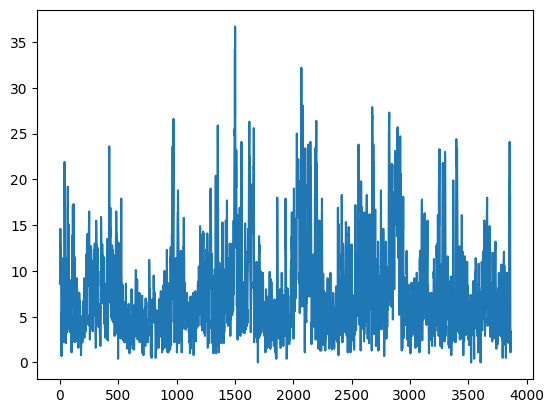

In [37]:
data['wind_speed'].plot()

# Wind

In [5]:
import sympy as sp
import math
import numpy as np

t = np.linspace(0, 10) # hours
wd = data['wind_direction'] # degrees
ws = data['wind_speed'] # km/h

cable_length = 100 # m
cable_radius = 0.01 # m

cD = 0.5 # drag coefficient -- for a cylinder #! will differ for different cables

air_density =  1.229 # kg/m^3 -- at sea level

def area_hit(wind_angle):
    return 2 * np.pi * cable_radius * cable_length * np.cos(wind_angle * np.pi / 180) # m^2 #! assume 0 degrees means wind is perpendicular to the cable

mass_of_air = air_density * area_hit(wd) * ws**2 * cable_length # kg

F = 1/2 * air_density * ws**2 * area_hit(wd) * cD # N

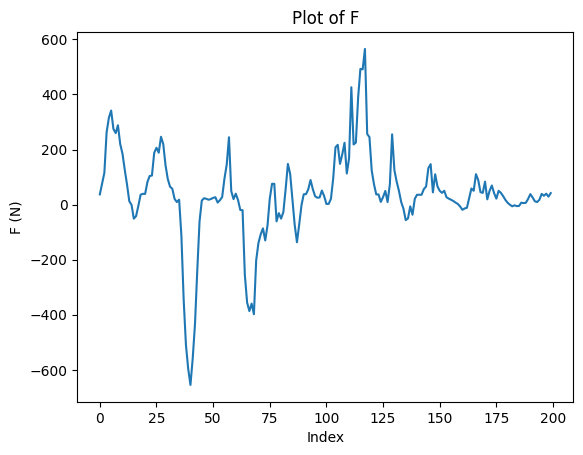

In [6]:
import matplotlib.pyplot as plt

plt.plot(F[:200])
plt.xlabel('Index')
plt.ylabel('F (N)')
plt.title('Plot of F')
plt.show()

# LIB TEST

In [7]:
from environment.models.weather_control_fixed import WeatherControlledFixedEnv

In [8]:
env = WeatherControlledFixedEnv(fibre_segments=3)

In [9]:
while not env.done:
    env.step()

QBERS = env.get_qber()

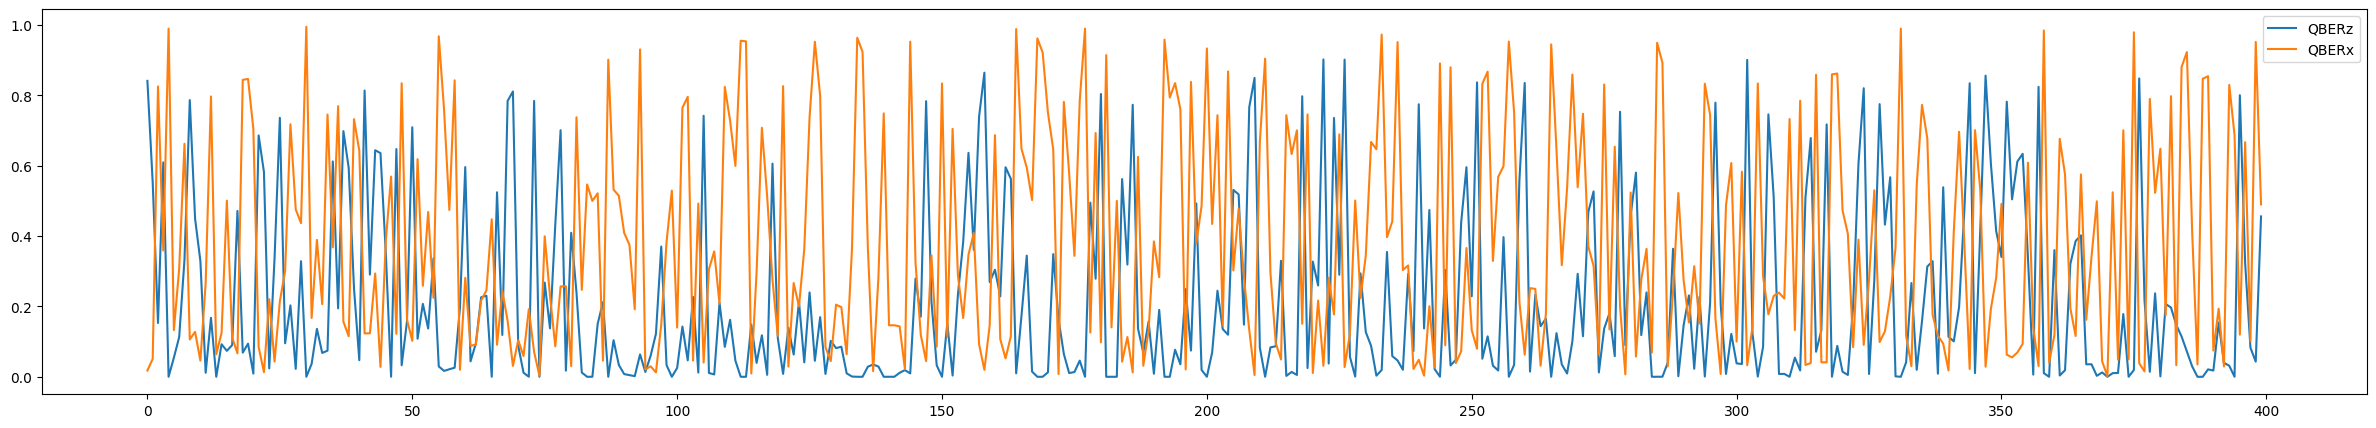

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(QBERS)
plt.legend(['QBERz', 'QBERx'])
plt.show()

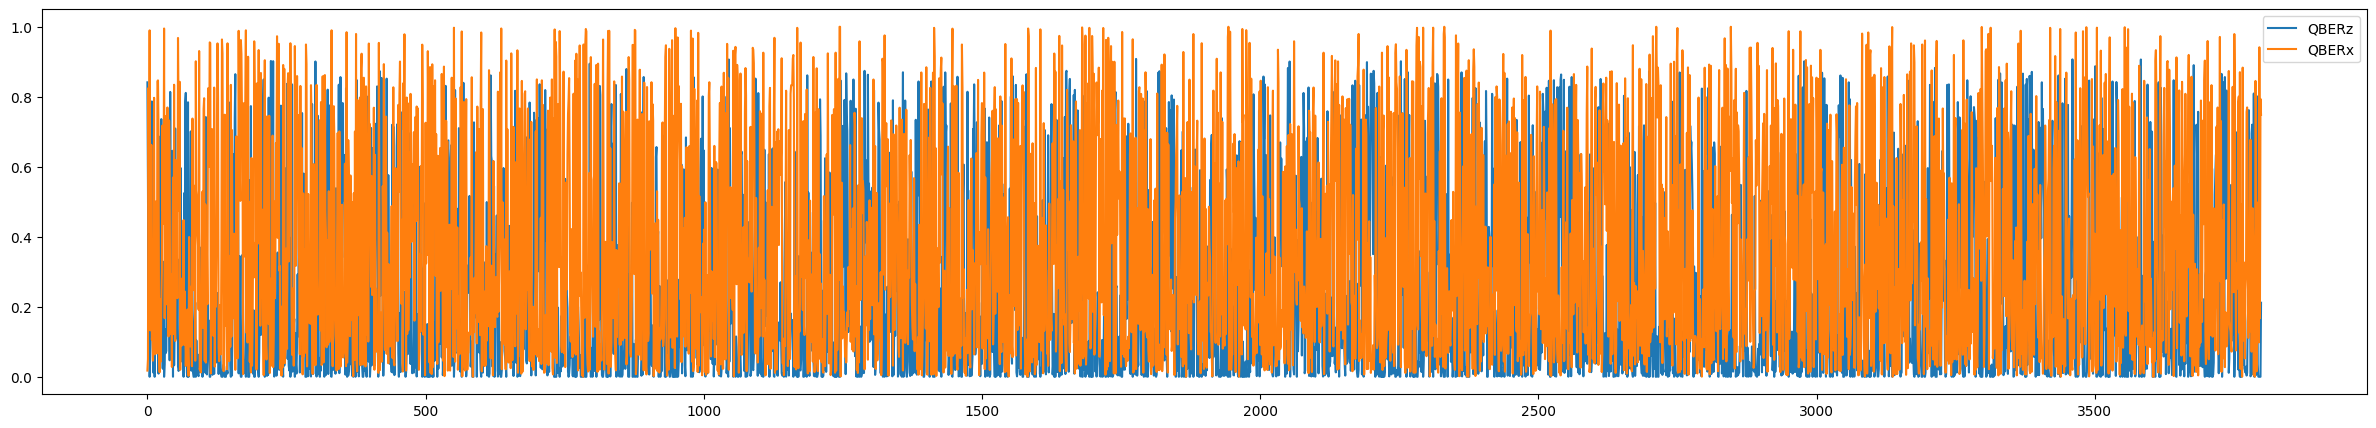

In [11]:
env.max_steps = 3800
env.reset()
while not env.done:
    env.step()

QBERS = env.get_qber()
plt.figure(figsize=(30, 5))
plt.plot(QBERS)
plt.legend(['QBERz', 'QBERx'])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Split the QBER data into two separate arrays
QBERz = QBERS[:, 0]
QBERx = QBERS[:, 1]

# Split the QBER data into training and test sets
QBERz_train, QBERz_test, QBERx_train, QBERx_test = train_test_split(QBERz, QBERx, test_size=0.05, random_state=42)

# Normalize the QBER data
normalized_QBERz_train = (QBERz_train - np.min(QBERz_train)) / (np.max(QBERz_train) - np.min(QBERz_train))
normalized_QBERz_test = (QBERz_test - np.min(QBERz_train)) / (np.max(QBERz_train) - np.min(QBERz_train))
normalized_QBERx_train = (QBERx_train - np.min(QBERx_train)) / (np.max(QBERx_train) - np.min(QBERx_train))
normalized_QBERx_test = (QBERx_test - np.min(QBERx_train)) / (np.max(QBERx_train) - np.min(QBERx_train))

print(len(normalized_QBERz_test))

190


In [13]:
from data.utils.data_processing import load_historical_weather_data
weather_data = load_historical_weather_data()
n = len(weather_data) - len(QBERS)
weather_data = weather_data.iloc[:-n]

# Check if the length of the weather data and QBER data match
if not len(weather_data) == len(QBERS):
    raise ValueError("Length of weather data and QBER data do not match")

In [14]:
weather_data = weather_data.drop(columns=['time'])

In [15]:
print(weather_data)

      wind_speed  wind_direction
0            8.6           285.0
1            9.0           299.0
2           11.1           299.0
3           14.0           314.0
4           14.6           320.0
...          ...             ...
3795         0.5           315.0
3796         1.4           360.0
3797         1.5           346.0
3798         1.8           360.0
3799         4.0            27.0

[3800 rows x 2 columns]


In [16]:
# Split the QBER data into training and test sets
ws_train, ws_test, wd_train, wd_test = train_test_split(weather_data['wind_speed'], weather_data['wind_direction'], test_size=0.05, shuffle=False, random_state=42)

# Normalize the wind speed data
normalized_ws_train = (ws_train - np.mean(ws_train)) / np.std(ws_train)
normalized_ws_test = (ws_test - np.mean(ws_train)) / np.std(ws_train)
# Normalize the wind direction data
normalized_wd_train = (wd_train - np.mean(wd_train)) / np.std(wd_train)
normalized_wd_test = (wd_test - np.mean(wd_train)) / np.std(wd_train)

normalized_ws_train = normalized_ws_train.to_numpy()
normalized_ws_test = normalized_ws_test.to_numpy()
normalized_wd_train = normalized_wd_train.to_numpy()
normalized_wd_test = normalized_wd_test.to_numpy()

# print(normalized_wd_test)

In [17]:
# import numpy as np
# n = len(normalized_QBERz_train) - 101

# # Create an empty array X
# X = np.zeros((n, 3, 100))
# y = np.zeros(n)

# # Iterate over the range of n
# for i in range(n):
#     # Get the previous 10 values of QBERz, wind speed, and wind direction
#     qberz_values = normalized_QBERz_train[i:i+100]
#     wind_speed_values = normalized_ws_train[i:i+100]
#     wind_direction_values = normalized_wd_train[i:i+100]
    
#     # print(i+11)
#     # Store the values in the array X
#     X[i] = np.array([qberz_values, wind_speed_values, wind_direction_values])
#     y[i] = normalized_QBERz_train[i+101]

# # Print the array X
# print(X.shape)
# print(y.shape)

In [18]:
import keras
import keras.layers
from tqdm.keras import TqdmCallback

# Define the model architecture
model = keras.models.Sequential()
model.add(keras.layers.LSTM(200, input_shape=(2,1), activation='relu', return_sequences=True))
model.add(keras.layers.LSTM(100, activation='relu'))
model.add(keras.layers.Dense(56, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

# Train the model
model.fit(x=np.column_stack((normalized_ws_train, normalized_wd_train)), y=normalized_QBERz_train, epochs=10, batch_size=16, verbose=0, callbacks=[TqdmCallback()])

# Evaluate the model
loss = model.evaluate(x=np.column_stack((normalized_ws_test, normalized_wd_test)), y=normalized_QBERz_test)

# Make predictions
predictions = model.predict(x=np.column_stack((normalized_ws_test, normalized_wd_test)))

2024-07-04 09:51:46.214059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 09:51:46.326019: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-04 09:51:47.546851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is opti

6/6 [==============================] - 0s 2ms/step


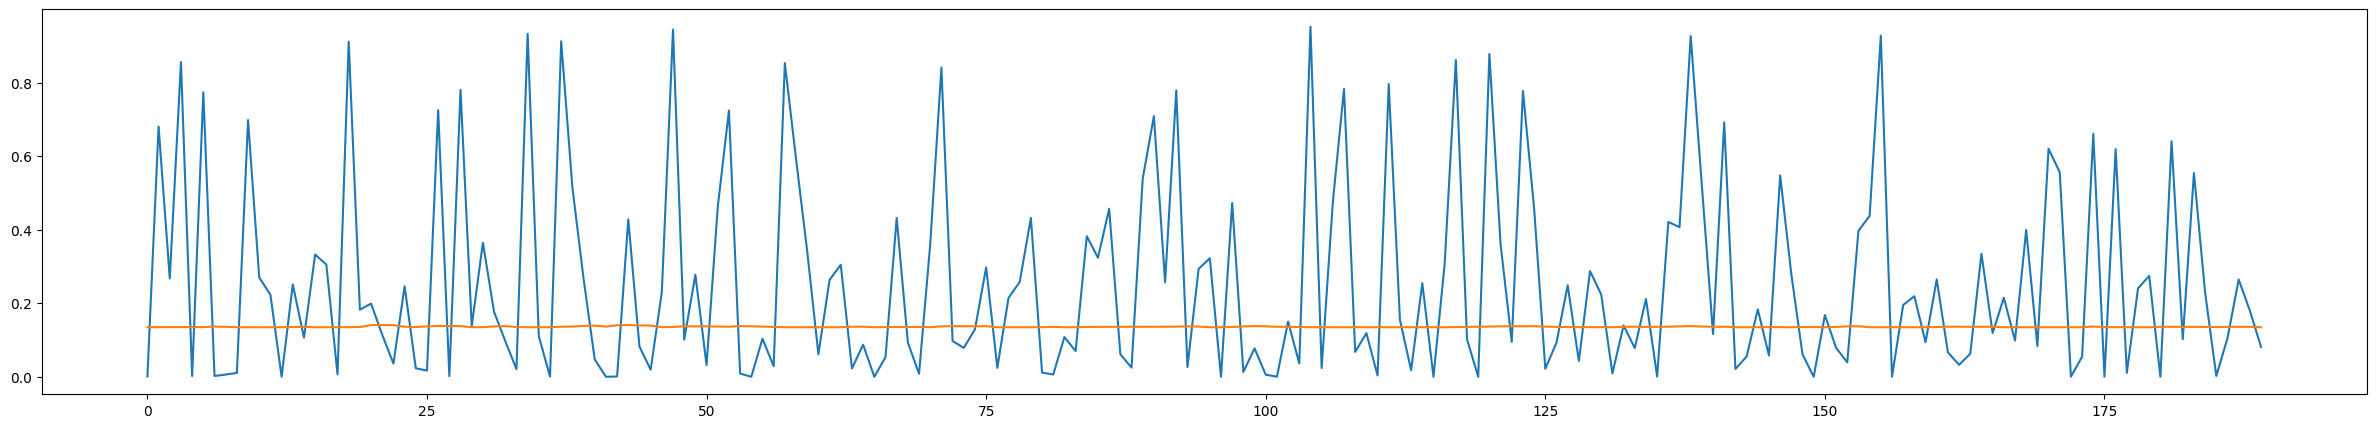

In [19]:
plt.figure(figsize=(30, 5))
plt.plot(normalized_QBERz_test)
plt.plot(predictions)

## Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor object
rf_regressor = RandomForestRegressor()

# Fit the model on the training data
rf_regressor.fit(np.column_stack((normalized_ws_train, normalized_wd_train)), normalized_QBERz_train)

# Make predictions on the test data
predictions = rf_regressor.predict(np.column_stack((normalized_ws_test, normalized_wd_test)))

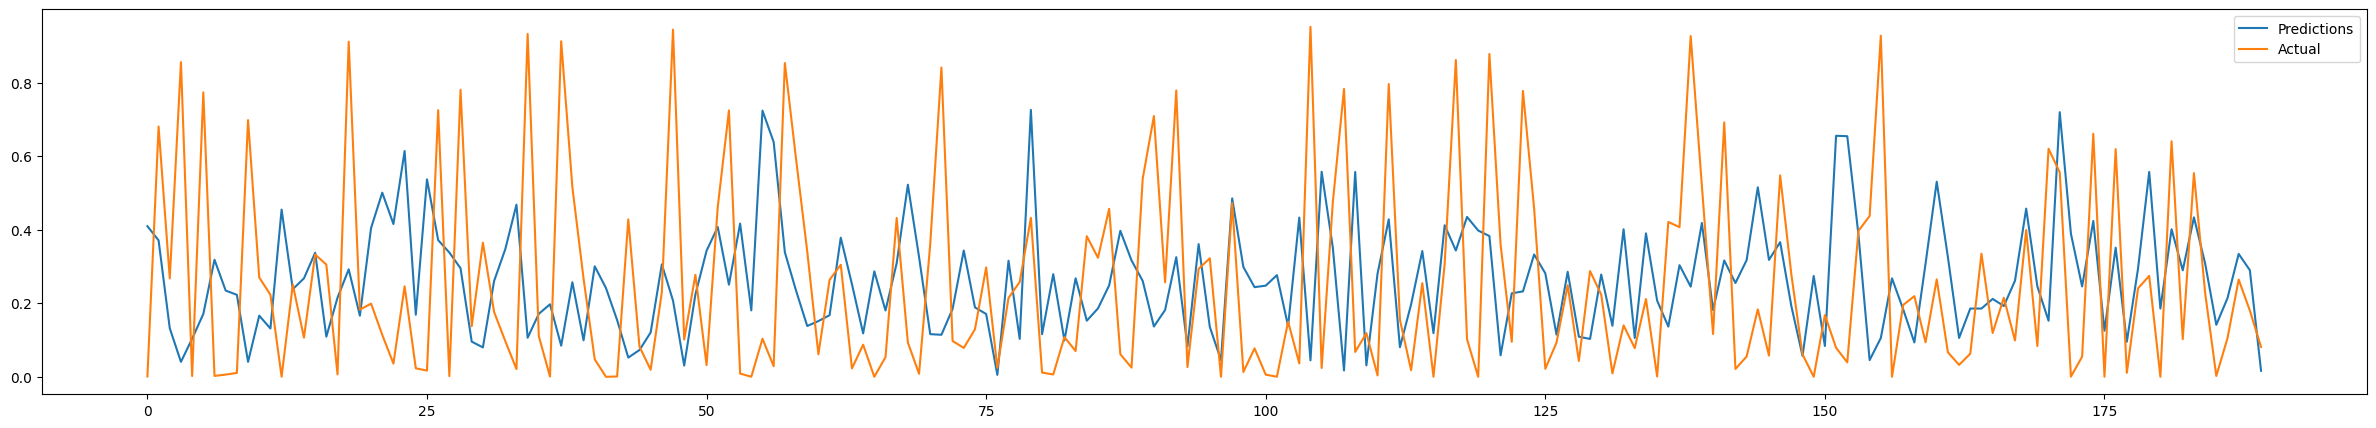

In [21]:
plt.figure(figsize=(30, 5))
plt.plot(predictions)
plt.plot(normalized_QBERz_test)
plt.legend(['Predictions', 'Actual'])

# Wind Speed/Direction to Force inference

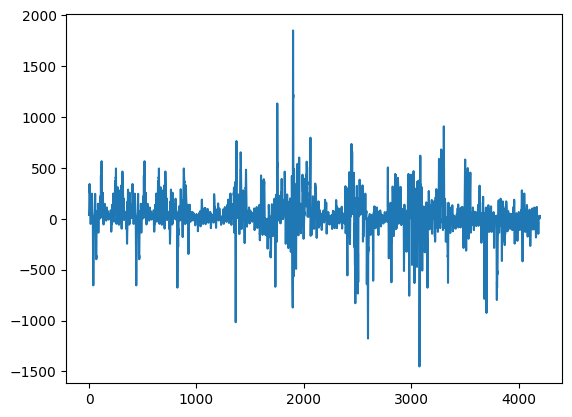

In [22]:
plt.plot(env.Fs[1])

In [23]:
forces = np.array(env.Fs[1])

normalized_forces = (forces - forces.mean()) / forces.std()
print(normalized_forces)

n_forces_train = normalized_forces[:len(normalized_ws_train)]
n_forces_test = normalized_forces[len(normalized_ws_train):(len(normalized_ws_train)+len(normalized_ws_test))]

[ 0.0097024   0.2254592   0.44482305 ... -0.17209223 -0.16076339
 -0.04267518]


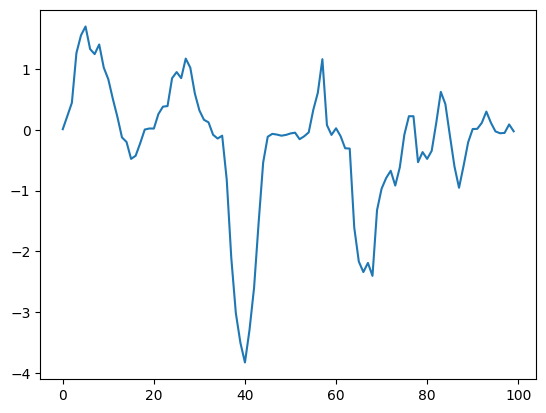

In [24]:
plt.plot(n_forces_train[:100])
# plt.plot(normalized_wd_train)
# plt.plot(normalized_ws_train)

In [25]:
import keras
from tqdm.keras import TqdmCallback

import keras.layers

# Define the model architecture
model = keras.models.Sequential()
model.add(keras.layers.LSTM(200, input_shape=(2,1), activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x=np.column_stack((normalized_ws_train, normalized_wd_train)), y=n_forces_train, epochs=10000, batch_size=32, verbose=0, callbacks=[TqdmCallback()])

# Evaluate the model
loss = model.evaluate(x=np.column_stack((normalized_ws_test, normalized_wd_test)), y=n_forces_test)

# Make predictions
predictions = model.predict(x=np.column_stack((normalized_ws_train, normalized_wd_train)))


100%|██████████| 10000/10000 [57:31<00:00,  2.90epoch/s, loss=0.665] 


113/113 [==============================] - 0s 1ms/step


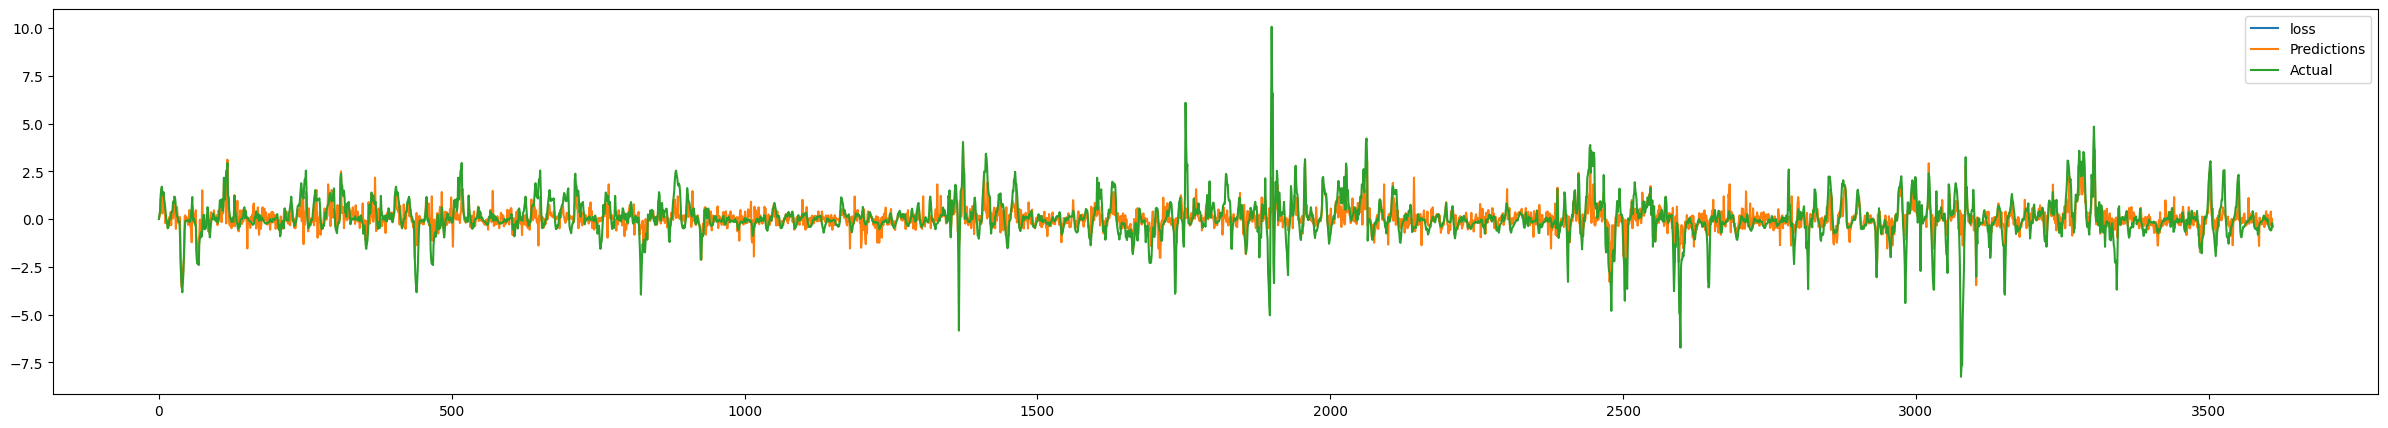

In [29]:
plt.figure(figsize=(30, 5))
plt.plot(predictions[:,0])
plt.plot(n_forces_train)
plt.legend(['Predictions', 'Actual'])
plt.show()

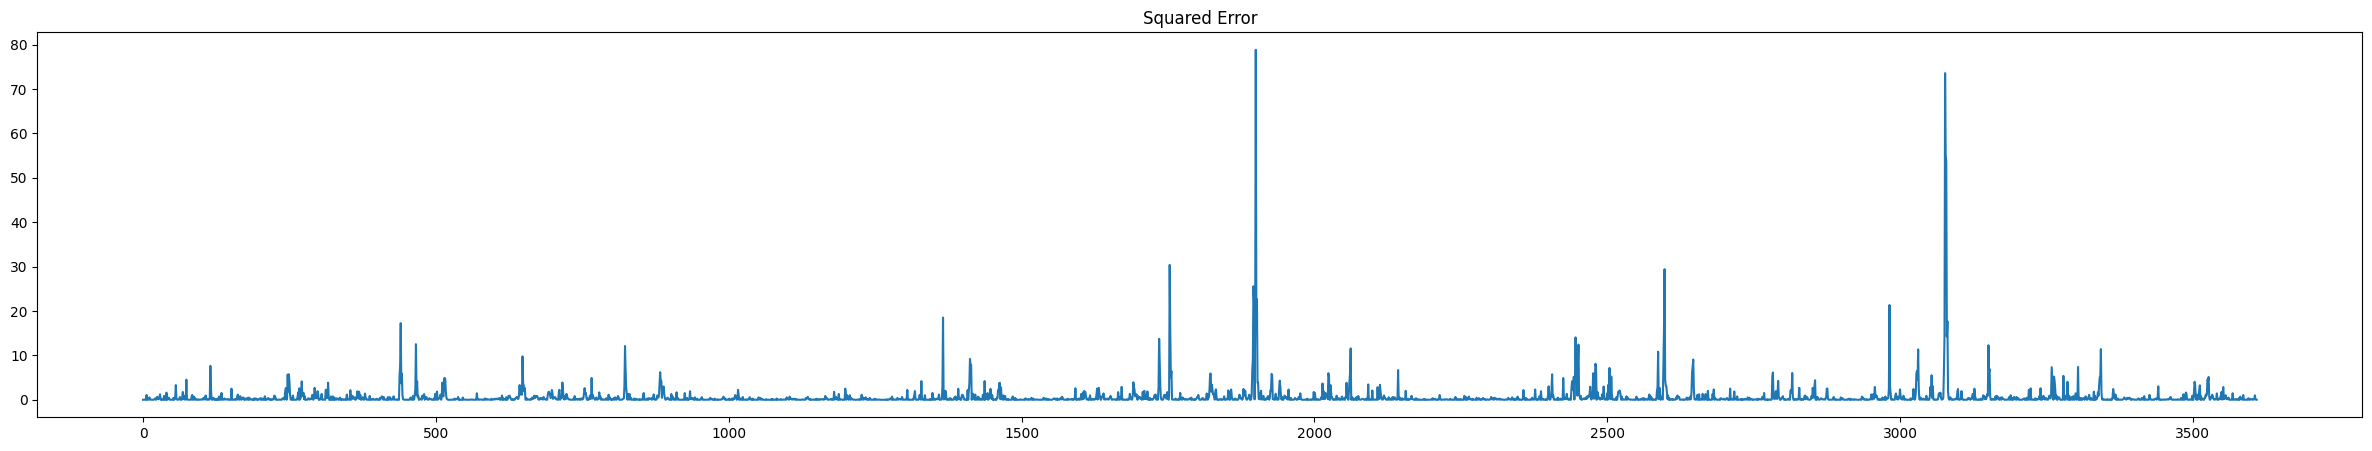

In [36]:
plt.figure(figsize=(30, 5))
plt.title('Squared Error')
plt.plot((predictions[:,0] - n_forces_train)**2)

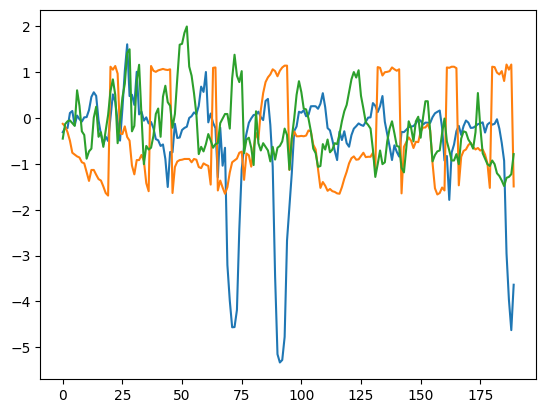

In [27]:
plt.plot(n_forces_test)
plt.plot(normalized_wd_test)
plt.plot(normalized_ws_test)

In [ ]:
data